In [1]:
import pandas as pd


df = pd.read_csv('movie_with_summary.csv')


df.head()

/var/folders/nd/262_rjl56cs3q3l_3stx5hsw0000gn/T/ipykernel_34561/817726617.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Unnamed: 0,title,plot_synopsis,gen_summary
0,0,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","""Mr. Holland's Opus"" follows the life of a ded..."
1,1,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","""Scarface"" follows Cuban immigrant Tony Montan..."
2,5,Flightplan,Kyle Pratt (Jodie Foster) is a propulsion engi...,"After her husband's sudden death, a grieving w..."
3,6,Little Caesar,Small-time Italian-American criminals Caesar E...,"""Little Caesar"" follows the rise and fall of a..."
4,7,Savages,The movie begins with a video being shot of me...,Two marijuana entrepreneurs in California are ...


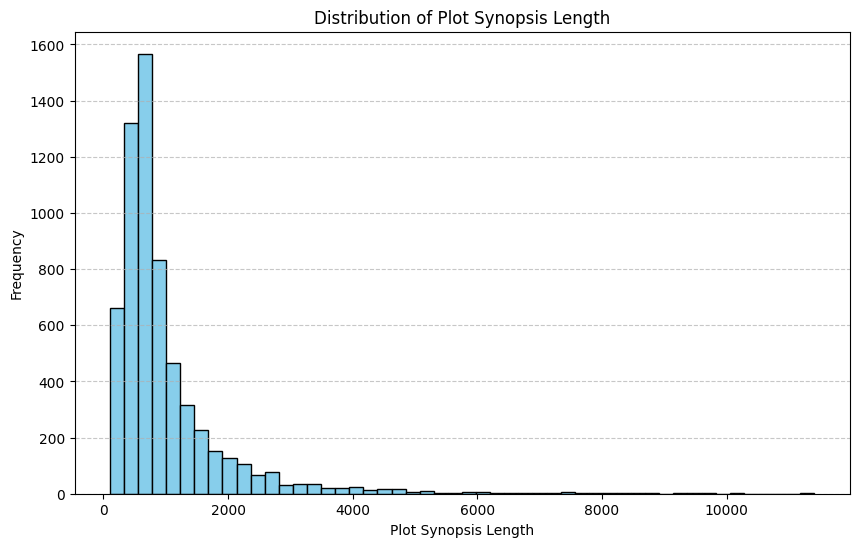

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['plot_synopsis'].apply(lambda x: len(x.split())), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Plot Synopsis Length')
plt.xlabel('Plot Synopsis Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [3]:
# Lower case
df['gen_summary'] = df['gen_summary'].apply(lambda x: x.lower())

In [4]:
# Remove punctuation and numbers
import re
df['gen_summary'] = df['gen_summary'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [5]:
# Tokenize text
from nltk.tokenize import word_tokenize
df['gen_summary'] = df['gen_summary'].apply(lambda x: word_tokenize(x))

In [6]:
# Remove  Stopwords
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
df['gen_summary'] = df['gen_summary'].apply(lambda x: [w for w in x if not w in stop_words])

In [7]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['gen_summary'] = df['gen_summary'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [12]:
# Drop dupes
df = df.drop_duplicates(subset=['title'])

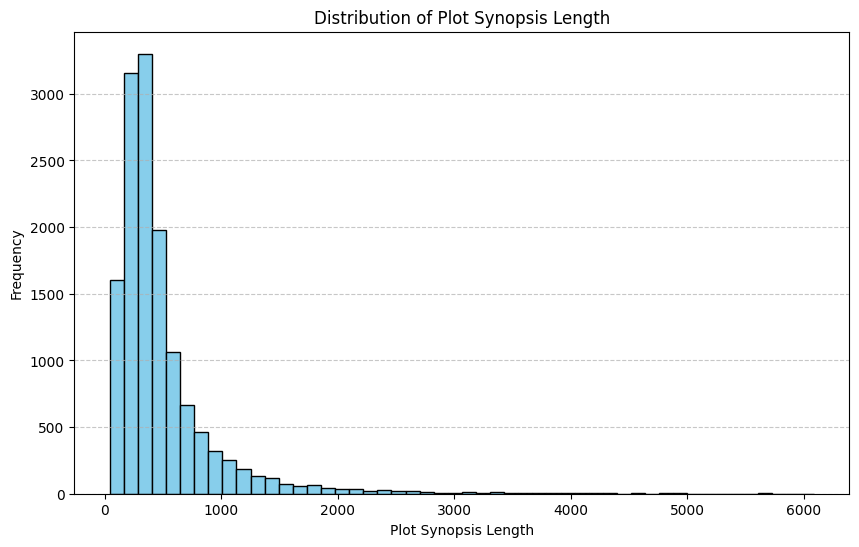

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['plot_synopsis'].apply(len), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Plot Synopsis Length')
plt.xlabel('Plot Synopsis Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [15]:
# DF with tags added to plot
df['plot_synopsis_str'] = df['plot_synopsis'].apply(lambda x: ' '.join(map(str, x)))
df_combined = pd.DataFrame({'title': df['title'],
    'combined_synopsis': df['plot_synopsis_str'] + ' ' + df['tags']
})

In [16]:
df_combined['plot_word_count'] = df_combined['combined_synopsis'].apply(lambda x: len(x.split(' ')))
df_2000 = df_combined[df_combined['plot_word_count'] < 2000].copy()
df_2000 = df_2000.drop(columns = 'plot_word_count', axis = 1)

In [140]:
len(df_2000)

13497

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df_2000['combined_synopsis'])

In [18]:
def find_recommendation(text):
    user_tf_idf_vector = tf_idf_vectorizer.transform([text])
    cos_similarities = linear_kernel(user_tf_idf_vector, tf_idf_matrix).flatten()
    similar_movies = pd.DataFrame({'title': df_2000['title'], 'similarity': cos_similarities})
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)
    recommendations = f"Top 5 recommendations {similar_movies.head(10)['title'].tolist()}"
    return similar_movies.head(10)

In [24]:
print(find_recommendation('star wars, interstellar, star trek, arrival'))

                                      title  similarity
14305                        American Honey    0.317449
9228                    L'uomo delle stelle    0.189027
10963                           Star Fox 64    0.145180
11486                        American Ninja    0.133392
8199                              Meatballs    0.128476
12887                            Glory Road    0.123035
2219                          The Lost Boys    0.122743
9949   Robot Chicken: Star Wars Episode III    0.118982
9376        Bucky Larson: Born to Be a Star    0.118233
10487              Robot Chicken: Star Wars    0.112438


In [20]:
df['plot_word_count'] = df['plot_synopsis'].apply(lambda x: len(x))
df_2000_new = df[df['plot_word_count'] < 2000].copy()
df_2000_new = df_2000_new.drop(columns = 'plot_word_count', axis = 1)

In [21]:
tf_idf_vectorizer_new = TfidfVectorizer(stop_words='english')
tf_idf_matrix_new = tf_idf_vectorizer_new.fit_transform(df_2000_new['plot_synopsis_str'])

In [22]:
def find_recommendation_new(text):
    user_tf_idf_vector = tf_idf_vectorizer_new.transform([text])
    cos_similarities = linear_kernel(user_tf_idf_vector, tf_idf_matrix_new).flatten()
    similar_movies = pd.DataFrame({'title': df_2000_new['title'], 'similarity': cos_similarities})
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)
    recommendations = f"Top 5 recommendations {similar_movies.head(10)['title'].tolist()}"
    return similar_movies.head(10)

In [23]:
print(find_recommendation_new('film about a drug addict trying to get his life back'))

                          title  similarity
7132            The Last Minute    0.177485
927            Drugstore Cowboy    0.164543
1680   The Panic in Needle Park    0.161674
9925            Cocaine Cowboys    0.156181
11575               Little Fish    0.155184
11667        Permanent Midnight    0.152150
5503                    Traffic    0.138874
6998   Number One with a Bullet    0.136051
11755            Out for a Kill    0.132564
1064             The Good Thief    0.124301


In [9]:
df['summary_str'] = df['gen_summary'].apply(lambda x: ' '.join(map(str, x)))

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tf_idf_vectorizer_2 = TfidfVectorizer(stop_words='english')
tf_idf_matrix_2 = tf_idf_vectorizer_2.fit_transform(df['summary_str'])

In [14]:
def find_recommendation_2(text):
    user_tf_idf_vector = tf_idf_vectorizer_2.transform([text])
    cos_similarities = linear_kernel(user_tf_idf_vector, tf_idf_matrix_2).flatten()
    similar_movies = pd.DataFrame({'title': df['title'], 'similarity': cos_similarities})
    similar_movies = similar_movies.sort_values(by='similarity', ascending=False)
    recommendations = f"Top 5 recommendations {similar_movies.head(10)['title'].tolist()}"
    return similar_movies.head(10)

In [15]:
print(find_recommendation_2('film about a drug addict trying to get his life back'))

                 title  similarity
1190        Wonderland    0.273773
611        Born to Win    0.272636
2222              Spun    0.240560
3838       Killing Zoe    0.236125
509   Drugstore Cowboy    0.223788
2998           Traffic    0.212982
5408    Pistol Whipped    0.197774
3922            Twelve    0.197580
2963            Snitch    0.190391
4607   Cocaine Cowboys    0.181020


In [18]:
print(find_recommendation_2('British crime comedy with diverse characters, chaotic plots, and a stolen diamond'))

                          title  similarity
2459                     Snatch    0.306126
1201              Blood Diamond    0.271028
3239    All About the Benjamins    0.245619
2248       Diamonds Are Forever    0.244054
3300                Blue Streak    0.201469
4403                    Botched    0.181986
313             Very Bad Things    0.147833
3487           Star of Midnight    0.146696
122                  Love Happy    0.142539
3470  Carry On... Up the Khyber    0.138896


In [27]:
print(find_recommendation_2("film about finding a new planet for humanity space"))

                   title  similarity
1208           Moonraker    0.284196
493   Planet of the Apes    0.266040
551              Solaris    0.262060
2454  Jetsons: The Movie    0.259254
2962            Solyaris    0.259252
2335    Forbidden Planet    0.255302
3710  Starship Invasions    0.254702
1960           Dark Star    0.252477
2286       Lost in Space    0.240249
5146         Upside Down    0.237016
